## Day 34 Lecture 1 Assignment

In this assignment, we will learn about SVR. We will use the absenteeism at work dataset loaded below and analyze the model generated for this dataset.

In [1]:
%matplotlib inline

import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
absent = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Absenteeism_at_work.csv', sep=';')

In [3]:
absent.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


We previously used this dataset for KNN regression. Recall that we removed all correlated columns as well as columns that are a function of two or more other columns (like BMI and weight and height) as well as columns that are not useful to us (like ID).
We also created dummy variables for the categorical columns in our dataset.
Finally, we split the data into test and train (with test being 20% of the data).

Perform these actions below.

In [4]:
# find occurances of correlation coeficient over .9
def get_high_corrs(df):
  corrs = df.corr()
  selected_columns = []
  for i in corrs.columns:
    for j in corrs[i].values:
      if j >= abs(.9) and j != 1:
        selected_columns.append(i)
  return selected_columns

In [5]:
get_high_corrs(absent)

['Weight', 'Body mass index']

In [6]:
# check which column has more unique values and drop that column
print(absent['Weight'].nunique())
print(absent['Body mass index'].nunique())

# also dropping 'ID' since we don't need it
absent.drop(['Weight', 'ID', 'Disciplinary failure'], axis=1, inplace=True)

26
17


In [7]:
# absent = pd.get_dummies(absent, columns=['Reason for absence', 'Month of absence', 'Day of the week', 'Seasons', 'Education'], drop_first=True)

In [8]:
from sklearn.model_selection import train_test_split

X = absent.drop('Absenteeism time in hours', axis=1)
y = absent['Absenteeism time in hours']


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)

Scale the independent variables using the standard scaler

In [9]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_sc = scaler.fit_transform(X_train)
# X_test_sc = scaler.transform(X_test)

In [16]:
# answer below:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


num_features = ['Transportation expense', 'Distance from Residence to Work',
       'Service time', 'Age', 'Work load Average/day ', 'Hit target', 'Son',
       'Social drinker', 'Social smoker', 'Pet', 'Height', 'Body mass index']
cat_features = ['Reason for absence', 'Month of absence', 'Day of the week', 'Seasons', 'Education']

scaler = StandardScaler()
onehot = OneHotEncoder(drop='first', sparse=False)

preprocessor = ColumnTransformer(transformers=[('num', scaler, num_features),
                                               ('cat', onehot, cat_features)])

In [17]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.fit(X_test)

In [22]:
# # This threw up the error message:
#   # Shape of passed values is (592, 59), indices imply (592, 55)
# # answer below:
# from sklearn import feature_extraction
# onehot_features = preprocessor.named_transformers_['cat'].get_feature_names()
# all_features = num_features + list(onehot_features)

# pd.DataFrame(X_train_proc, columns=all_features, index=X_train.index).head()

Generate an SVR model to predict the number of hours of absenteeism. Compare the train and test scores.

In [13]:
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
svr = SVR(kernel='linear', C=100, epsilon=.5)
svr.fit(X_train_sc, y_train)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.5, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [29]:
from statsmodels.tools.eval_measures import rmse
print('Training R2: ', svr.score(X_train_sc, y_train))
print('Testing R2: ', svr.score(X_test_sc, y_test))

y_train_preds = svr.predict(X_train_sc)
y_test_preds = svr.predict(X_test_sc)

print('Training RMSE: ', rmse(y_train, y_train_preds))
print('Testing RMSE: ', rmse(y_test, y_test_preds))

Training R2:  0.1291837049530431
Testing R2:  0.07929495702984246
Training RMSE:  12.920013270047694
Testing RMSE:  10.499872628228966


If you are unhappy with your model's performance, perform a grid search to optimize C. You may also want to compare something other than R squared, like MSE, and could try some other kernels than just linear.

In [15]:
# # answer below:
from sklearn.model_selection import GridSearchCV

grid = {'C': [.1, 1, 10, 1000], 'kernel': ['poly', 'rbf']}
svr_cv = GridSearchCV(SVR(), grid, cv=5)
svr_cv.fit(X_train_sc, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 1000], 'kernel': ['poly', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [25]:
svr_cv.best_params_

{'C': 10, 'kernel': 'rbf'}

In [30]:
# answer below:
print('Training R2: ', svr_cv.score(X_train_sc, y_train))
print('Testing R2: ', svr_cv.score(X_test_sc, y_test))

y_train_preds = svr_cv.predict(X_train_sc)
y_test_preds = svr_cv.predict(X_test_sc)

print('Training RMSE: ', rmse(y_train, y_train_preds))
print('Testing RMSE: ', rmse(y_test, y_test_preds))

Training R2:  0.23830707547879093
Testing R2:  0.11090371411197186
Training RMSE:  12.083413760181116
Testing RMSE:  10.31806282329013


Create a homoscedasticity (residual) plot. Look back at your KNN regression exercise (Day 32 Lecture 1). How do your model results compare?

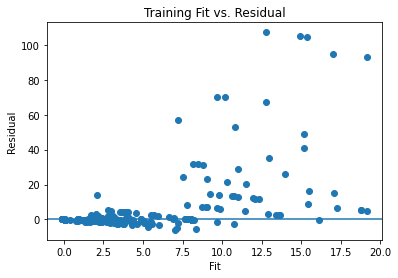

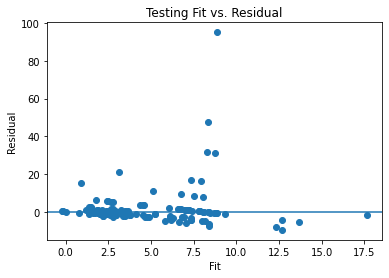

In [33]:
train_resid = y_train - y_train_preds
test_resid = y_test - y_test_preds


plt.scatter(y_train_preds, train_resid)
plt.xlabel('Fit')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Training Fit vs. Residual')
plt.show()


plt.scatter(y_test_preds, test_resid)
plt.xlabel('Fit')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Testing Fit vs. Residual')
plt.show()


The KNN plot had many more large residuals than these plots. Interestingly, the RMSE scores for the two models were comparable. 